In [36]:
import argparse
import torch
from path import Path
from torch.utils.data import DataLoader
from model.VAE import VAEAnomalyTabular
from vae_dataset import VAEDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

In [37]:
parser = argparse.ArgumentParser()
parser.add_argument('--input-size', '-i', type=int, default=9, dest='input_size', help='Number of input features. In 1D case it is the vector length, in 2D case it is the number of channels')
parser.add_argument('--latent-size', '-l', type=int, default=4, dest='latent_size', help='Size of the latent space')
parser.add_argument('--hidden-1', '-h1', type=int, default=500, dest='hidden_1', help='Size of hidden layer 1 in encoder and decoder')
parser.add_argument('--hidden-2', '-h2', type=int, default=200, dest='hidden_2', help='Size of hidden layer 2 in encoder and decoder')
parser.add_argument('--num-resamples', '-L', type=int, dest='num_resamples', default=10,
                    help='Number of resamples in the latent distribution during training')
parser.add_argument('--epochs', '-e', type=int, dest='epochs', default=20, help='Number of epochs to train for')
parser.add_argument('--batch-size', '-b', type=int, dest='batch_size', default=32)
parser.add_argument('--device', '-d', '--accelerator', type=str, dest='device', default='gpu', help='Device to use for training. Can be cpu, gpu or tpu', choices=['cpu', 'gpu', 'tpu'])
parser.add_argument('--lr', type=float, dest='lr', default=1e-3, help='Learning rate')
parser.add_argument('--no-progress-bar', action='store_true', dest='no_progress_bar')
parser.add_argument('--steps-log-loss', type=int, dest='steps_log_loss', default=1_000, help='Number of steps between each loss logging')
parser.add_argument('--steps-log-norm-params', type=int, 
                    dest='steps_log_norm_params', default=1_000, help='Number of steps between each model parameters logging')

args = parser.parse_args('')

In [38]:
dataset = pd.read_csv('data/HI_Small_Trans_ordinal.csv')

scaler = StandardScaler()
temp = dataset.drop(columns=['Is Laundering'])
temp = scaler.set_output(transform='pandas').fit_transform(temp)
dataset = pd.concat([temp, dataset['Is Laundering']], axis=1)

# work on a subset of 25,000 class 0 and ~5,000 class 1
temp = dataset[dataset['Is Laundering'] == 0].sample(25_000, random_state=0)
# first separate out test set
class1 = dataset[dataset['Is Laundering']==1]
dataset = pd.concat([temp, class1], axis=0)
num_sample = len(class1)
test_ratio = round(num_sample / len(dataset[dataset['Is Laundering'] == 0]), 4)
dataset = dataset[dataset['Is Laundering'] == 0]
# test set has only class0
dataset, test_set = train_test_split(dataset, test_size=test_ratio, random_state=0)
test_set = VAEDataset(test_set.drop(columns=['Is Laundering']).reset_index(drop=True))
test_dloader = DataLoader(test_set, args.batch_size, shuffle=False)

# class1 has all class1 rows
class1 = VAEDataset(class1.drop(columns=['Is Laundering']).reset_index(drop=True))
class1_dloader = DataLoader(class1, args.batch_size, shuffle=False)

checkpointfile = torch.load(
    'C:\\YKT\\NUS_MComp\\CS5340_project\\comp5340\\lightning_logs\\version_50\\checkpoints\\last.ckpt')
net = VAEAnomalyTabular(args.input_size, args.latent_size, args.hidden_1, args.hidden_2, args.num_resamples, lr=args.lr)
net.load_state_dict(checkpointfile["state_dict"])
net.eval()

y_pred = []
y_prob = []
y_true = [False] * len(test_set)
for batch in test_dloader:
    #print("Test set (class 0)")
    with torch.no_grad():
        #print(net.is_anomaly(batch))
        prob, pred = net.is_anomaly(batch)
        prob, pred = prob.cpu().numpy(), pred.cpu().numpy()
        y_pred.extend(pred)
        y_prob.extend(prob)

temp = [True] * len(class1)
y_true.extend(temp)

for batch in class1_dloader:
    #print("Test set (class 1)")
    with torch.no_grad():
        #print(net.is_anomaly(batch))
        prob, pred = net.is_anomaly(batch)
        prob, pred = prob.cpu().numpy(), pred.cpu().numpy()
        y_pred.extend(pred)
        y_prob.extend(prob)

print(confusion_matrix(y_true, y_pred))
print(f1_score(y_true, y_pred))

[[4471  707]
 [1338 3839]]
0.7896739689396277


In [39]:
import sklearn
import sklearn.metrics as metrics
import numpy as np

# Getting classes from a vector of fraud probabilities and a threshold
def get_class_from_fraud_probability(fraud_probabilities, threshold=0.5):
    
    predicted_classes = [0 if fraud_probability<threshold else 1 
                         for fraud_probability in fraud_probabilities]

    return predicted_classes

def threshold_based_metrics(fraud_probabilities, true_label, thresholds_list):
    
    results = []
    
    for threshold in thresholds_list:
    
        predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold=threshold)
    
        (TN, FP, FN, TP) = metrics.confusion_matrix(true_label, predicted_classes).ravel()
    
        MME = (FP+FN)/(TN+FP+FN+TP)
    
        TPR = TP/(TP+FN)
        TNR = TN/(TN+FP)
    
        FPR = FP/(TN+FP)
        FNR = FN/(TP+FN)
        
        BER = 1/2*(FPR+FNR)
        
        Gmean = np.sqrt(TPR*TNR)
    
        precision = 0
        FDR = 0
        F1_score=0
        
        if TP+FP>0:
            precision = TP/(TP+FP)
            FDR=FP/(TP+FP)
        
        NPV = 0
        FOR = 0
        
        if TN+FN>0:
            NPV = TN/(TN+FN)
            FOR = FN/(TN+FN)
            
        
        if precision+TPR>0:
            F1_score = 2*(precision*TPR)/(precision+TPR)
    
        results.append([threshold, MME, TPR, TNR, FPR, FNR, BER, Gmean, precision, NPV, FDR, FOR, F1_score])
        
    results_df = pd.DataFrame(results,columns=['Threshold' ,'MME', 'TPR', 'TNR', 'FPR', 'FNR', 'BER', 'G-mean', 'Precision', 'NPV', 'FDR', 'FOR', 'F1 Score'])
    
    return results_df

In [40]:
threshold_list = np.round(np.linspace(0, 0.98, 50), 2).tolist()

In [41]:
y_prob = 1 - np.array(y_prob)
y_prob = y_prob.tolist()

In [42]:
results_df = threshold_based_metrics(y_prob, y_true, threshold_list)

In [43]:
results_df[['Threshold', 'TPR', 'FPR']]

,Threshold,TPR,FPR
0,0.00,1.000000,1.000000
1,0.02,1.000000,1.000000
2,0.04,1.000000,1.000000
3,0.06,1.000000,1.000000
4,0.08,1.000000,1.000000
5,0.10,1.000000,1.000000
6,0.12,1.000000,1.000000
7,0.14,1.000000,1.000000
8,0.16,1.000000,1.000000
9,0.18,1.000000,1.000000


In [44]:
FPR_list, TPR_list, threshold = sklearn.metrics.roc_curve(y_true, y_prob, drop_intermediate=False)

C:\Users\KT\AppData\Local\Temp\ipykernel_116340\2864828094.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(FPR_list, TPR_list, 'b', color='blue', label = 'AUC ROC Classifier = {0:0.3f}'.format(ROC_AUC))


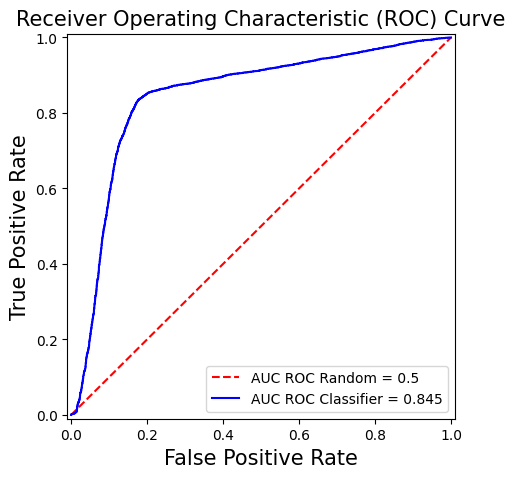

In [45]:
import matplotlib.pyplot as plt

def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")

ROC_AUC = metrics.auc(FPR_list, TPR_list)    
    
roc_curve, ax = plt.subplots(figsize=(5,5))
get_template_roc_curve(ax, "Receiver Operating Characteristic (ROC) Curve",fs=15)
ax.plot(FPR_list, TPR_list, 'b', color='blue', label = 'AUC ROC Classifier = {0:0.3f}'.format(ROC_AUC))
ax.legend(loc = 'lower right')

In [46]:
encoded = []
enc_labels = []
# collect 100 samples each for positive and negative class
sample_count = 0
for batch in test_dloader:
    #print("Test set (class 0)")
    for i in range(len(batch)):
        if sample_count < 2000:
            with torch.no_grad():
                encoded.append(net.encoder(batch[i]).squeeze(0).detach().cpu())
            enc_labels.append(0)
            sample_count += 1

for batch in class1_dloader:
    #print("Test set (class 1)")
    for i in range(len(batch)):
        if sample_count < 4000:
            with torch.no_grad():
                encoded.append(net.encoder(batch[i]).squeeze(0).detach().cpu())
            enc_labels.append(1)
            sample_count += 1

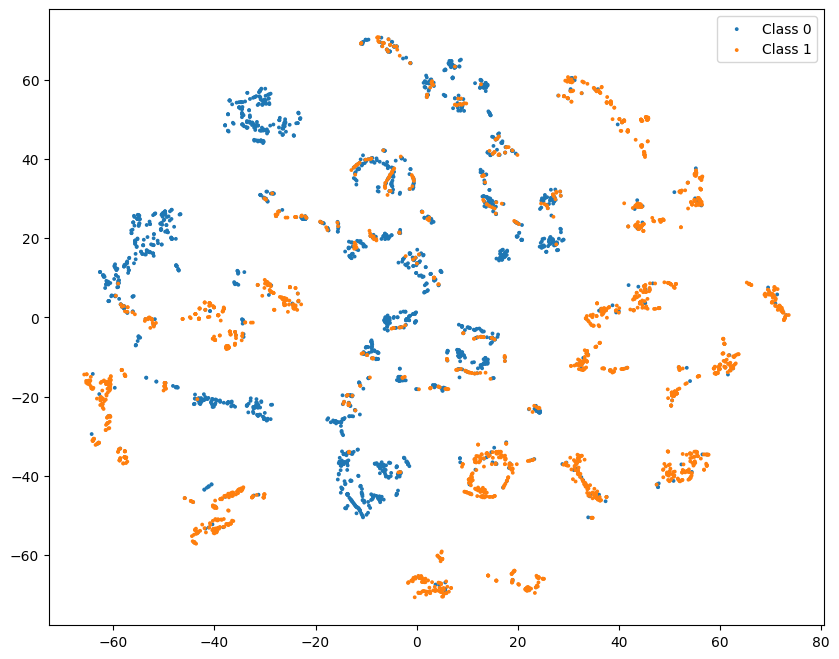

In [49]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(np.array(encoded))

enc_labels = np.array(enc_labels)

unique_labels = np.arange(2)

colors = plt.cm.tab10(enc_labels)

# Sort labels and corresponding colors
sorted_indices = np.argsort(enc_labels)
sorted_labels = enc_labels[sorted_indices]
sorted_colors = colors[sorted_indices]
sorted_tsne = tsne_results[sorted_indices]

plt.figure(figsize=(10,8))

for i in unique_labels:
    indices = np.where(sorted_labels == i)
    plt.scatter(sorted_tsne[indices, 0], sorted_tsne[indices, 1], color=sorted_colors[indices], label=f"Class {i}", s=3)

plt.legend()
plt.show()